## Work package 1.2 
### This notebook demonstrates running water quality measures using a multi-sensor approach, for an area of interest.
Note that:
- an area / domain of interst is assumed as a start point
- the processing resolution is determined from the space-time size of the AOI, in part to remain within sandbox memory limitations
- 
   

### Dependencies etc.

In [83]:
# --- --- 
import datacube
import numpy as np
import xarray as xr
import scipy as sp
import gc
from scipy import stats
import pandas as pd

from deafrica_tools.plotting import display_map, rgb

dc = datacube.Datacube(app='DoinWhatImdoin') #testing what difference the 'app' value makes...

In [84]:
# --- run code for functions that are called
%run _WQ_functions.py
%run _Build_annual_dataset-1.0.ipynb   #for now I have kept these functions in a notebook for the markdown

In [652]:
# --- controlling parameters and settings
verbose = True
test    = False
max_cells = 100000   #use this to test memory limits. Memory saving steps are going to be needed...
max_cells = 1000   #use this to test memory limits. Memory saving steps are going to be needed... (Results are not particularly sensitive to cell size)

In [653]:
# --- get the dictionary of all possible places for analysis ---
places_dict     = set_spacetime_domain()   
# --- extract an AOI for a given placename (could iterate through the dictionary keys as an alternative)
placename = 'Lake_Sulunga'   
placename = 'Ghana_River'   
placename = 'Lake_Tikpan'   
placename = 'Lake_vic_turbid'   
placename = 'SA_smalldam'   
placename = 'SA_smalldam1' 
placename = 'Lake Awassa'
placename = 'Lake Ziway'
placename = 'Lake Elmenteita'
placename = 'Lake Chamo'
placename = 'Lake_vic_algae'
placename = 'Lake_vic_algae'
placename = 'Lake_Manyara'
placename = 'Haartbeesport_dam'

# --- the functions set_spacetime_domain is used here to set a bunch of processing parameters
# --- when operationalising, this must be replaced but an approach that iterates through tiles or waterebodiies

spacetime_domain, grid_resolution, cell_area, resampling_option, year1, year2 \
                           = set_spacetime_domain(placename,'2000','2024',max_cells,verbose,False)     

Haartbeesport_dam AOI:  {'x': (27.7972, 27.91117), 'y': (-25.7761, -25.7275), 'time': ('2000', '2024')} Haartbeesport Dam  -- South Africa
Grid resolution will be: (220, 220)
Rough dimensions (x,y):  10  by  4 kilometres
Total cells is roughly:  1030
Cell area is:  0.0484  km2
Resampling : nearest
Site name:  Haartbeesport Dam  -- South Africa
Years: 2000 2024


In [654]:
# --- save the analysis parameters ---
y1,y2 = pd.DatetimeIndex([spacetime_domain['time'][0],spacetime_domain['time'][1]]).year[[0,1]]
parameters = {}
parameters['placename'] = placename
parameters['xyt'] = spacetime_domain
parameters['grid_resolution'], parameters['cell_area'], parameters['resampling_option'],parameters['year1'],parameters['year2'] = \
        grid_resolution,                   cell_area,                resampling_option,            y1,y2


### Build a multi-sensor dataset 
- flexibility is key here, and consistent naming so that measurements from multiple sensors can be unambiguously included in a single dataset for analysis
- keeping all data in a single dataset simplifies subsequent steps and retains flexibility, e.g., to add in new water quality algorithms
- a dictionary of instruments and sensors is used to rename all measurements to a common form
- since we are using annual geomedians, we don't need to harmonise dates, at this point, except for when using temperature data
- the approach is designed to be extendable to monthly composites


#### set a list of 'instruments' to be used in the analysis. Once methods are all in place this will not change except to support improvements.
- instrument names are used rather than satellite names, to avoid confusionFor these purposes, wofs is also an instrument name.
- the list is set up to be resuable when we move from geomedians to monthly composites


In [655]:
# --- set which instruments to use (this is checked later against the date range for each place)
# --- for Phase1, mapping, the main datasets are the geomedians. For monioring the local time-seres will be brought in as well as the geomedians.
# --- temperature is yet to be included.

_instruments_to_use = {
    'oli_agm'  : {'use': True },
    'oli'      : {'use': False},
    'msi_agm'  : {'use': True },
    'msi'      : {'use': False},
    'tm_agm'   : {'use': True },
    'tm'       : {'use': False},
    'tirs'     : {'use': False},  
    'wofs_ann' : {'use': True },
    'wofs_all' : {'use': False },  # wofs_all will be removed as it is better to derive from wofs_ann
    }
instruments_to_use = _instruments_to_use.copy()  #using a copy is helpful sometimes..

# --- don't try to use instruments for which there are no data 
check_instrument_dates(instruments_to_use,int(year1),int(year2))

# --- build the multivariate/multi-sensor dataset. 
#     Datacube calls are made to extract the primary data. 
#     Variables are-re-named and merged to a single dataset ---

ds             = build_wq_agm_dataset(spacetime_domain,instruments_to_use,verbose = verbose)

# --- retain a dictionary of the instruments and measurements that are on-hand ---
instruments    = instruments_list(instruments_to_use)[0]  # a list of the instruments  in use
            

oli_agm True
oli False
msi_agm True
msi False
tm_agm True
tm False
tirs False
wofs_ann True
wofs_all False

Building the dataset:
loading data for  oli_agm ...
loading data for  msi_agm ...
loading data for  tm_agm ...
loading data for  wofs_ann ...


In [656]:
#ds.chla.loc[dict(chla_measure='ndci_tm43_agm')].median(dim=('x','y'))*53 + 28

### Determine pixels that are water (sometimes, usually, permanent)

In [657]:
# --- controling parameters for water mapping on a pixel by pixel basis ---
WFTH = water_frequency_threshold_high = 0.5    #this threshold targets areas that are as like as not to be water at any time.
WFTL = water_frequency_threshold_low  = 0.1    #for pixel processing (rather than during summation)
PWT  = permanent_water_threshold      = 0.875  #used to map annual permanent water (value arrived at through testing)
SC   = sigma_coefficient              = 1.2    #used to map annual permanent water (value arrived at through tessting)
ds   = water_analysis(ds,
                   water_frequency_threshold= WFTH,
                   wofs_varname             = 'wofs_ann_freq',
                   permanent_water_threshold= PWT,
                   sigma_coefficient        = SC,
                   verbose                  = True,
                   test                     = test)

/opt/venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:236: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


### 5yr wofs frequency. 
#### A 5-year wofs frequency is needed to correctly identify the extent of water despite low wofs frequencies caused by floating vegetation. 

In [658]:
# This function calculates a running 5-year wofs frequency on the dataset
# --- The start and end values are calculated on the nearest 5 year window; otherwise the centre of the window
# --- If the duration of the geomedian series is less than 5 years the frequency is calculated on that shorter time series. 
# ! assuming the shape of the array is time,y,x and using array-based indexing rather than dataset labels.

def WOFS_5_year_frequency(ds, test = True):
    clearcount = np.zeros(ds.wofs_ann_freq.shape,dtype = 'int')
    wetcount   = np.zeros(ds.wofs_ann_freq.shape,dtype = 'int')
    freq       = np.zeros(ds.wofs_ann_freq.shape,dtype = 'float')
    
    length = ds.time.size
    window = 5
    # --- I am sure there is a simpler formulation, but this works! ---
    for i in np.arange(0,length):
        start = np.max([0,i-int(window/2)])
        end   = np.min([length,start+5])    
        start = np.min([start,length-5])
        start = np.max([start,0])
        if test: print(i,start,end)
    
        clearcount[i,:,:] = ds.wofs_ann_clearcount[start:end,:,:].sum(dim=('time'))
        
        wetcount[i,:,:]   = ds.wofs_ann_wetcount[start:end,:,:].sum(dim=('time'))
        if test : print(start,end,clearcount[i,:,:].sum(),clearcount.sum(),wetcount[i,:,:].sum(),wetcount.sum())

    np.divide(wetcount, clearcount, out = freq,where=(clearcount>0))

    if test : print(np.nanmean(freq),np.sum(wetcount), np.sum(clearcount))
    ds['wofs_5yr_freq']             = ds.wofs_ann_freq.dims, freq 
    ds['wofs_5yr_clearcount']       = ds.wofs_ann_freq.dims, clearcount 
    ds['wofs_5yr_wetcount']         = ds.wofs_ann_freq.dims, wetcount 
    if test : print(ds.wofs_5yr_freq.mean().item(),np.nanmean(freq),ds.wofs_5yr_wetcount.sum().item(),np.sum(wetcount),ds.wofs_5yr_clearcount.sum().item(), np.sum(clearcount))
    
    return(ds)
    

In [659]:
ds = WOFS_5_year_frequency(ds,False)

In [660]:
# --- create a 5-year water mask ---
ds['water_5yr'] = xr.where(ds.wofs_5yr_freq>0.45,ds.wofs_5yr_freq.astype('bool'),np.nan)


In [661]:
# --- Initiate a results dictionary containing the analysis parameters and the results
results = {}
results['parameters'] = parameters

#The annual water area can be saved as a pandas data frame with years as indexes:
results['annual_results'] = pd.DataFrame(
    {
     "time"    :ds.time,
     "year"    :pd.DatetimeIndex(ds.time).year,
     "area_km2":(ds.water_5yr.count(dim=('x','y'))*parameters['cell_area']).round(2)},     
    #index = pd.DatetimeIndex(ds_annual.time).year
    )

ds['agm_count']=('time','y','x'),np.zeros((ds.sizes['time'],ds.sizes['y'],ds.sizes['x']))

for instrument in 'oli_agm','tm_agm','msi_agm':
    if instrument in ds.data_vars:
        ds['agm_count'] = ds['agm_count'] + ds[instrument+'_count'].where(ds[instrument]==True,0)
        results['annual_results'].insert\
            (
            2,
            instrument,
            (ds[instrument])
            )

results['annual_results'].insert\
            (
            results['annual_results'].columns.size,
            'total_geomedian_count',
            ds['agm_count'].mean(dim=('x','y')).round()
            )


results['annual_results'].insert\
            (
            results['annual_results'].columns.size,
            'average_water_freq',
            (ds.wofs_ann_wetcount/ds.wofs_ann_clearcount).where(ds.water_5yr>0).mean(dim=('x','y'))
            )

### Add boolean variables to the geomedian time series to identify which sensors are avaialable each year


In [662]:
# --- Add boolean variables that indicate which instruments are available in the geomedian data series for a given year. For earlier years tm is available. 
# --- assume that the 'smad' will always be available and use this as an indicator 
# --- If the instrument is never available during the time series, the boolean variable is not added.
def detect_geomedian_instruments (ds_annual):
    for inst in 'oli_agm','tm_agm','msi_agm':
        if inst+'_smad' in ds_annual.data_vars:
            ds_annual[inst] = ('time'), np.zeros(ds_annual.sizes['time'],dtype ='bool')
            ds_annual[inst] = ~np.isnan(ds_annual[inst+'_smad'].mean(dim=('x','y')))
    return ds_annual
    
ds = detect_geomedian_instruments(ds)

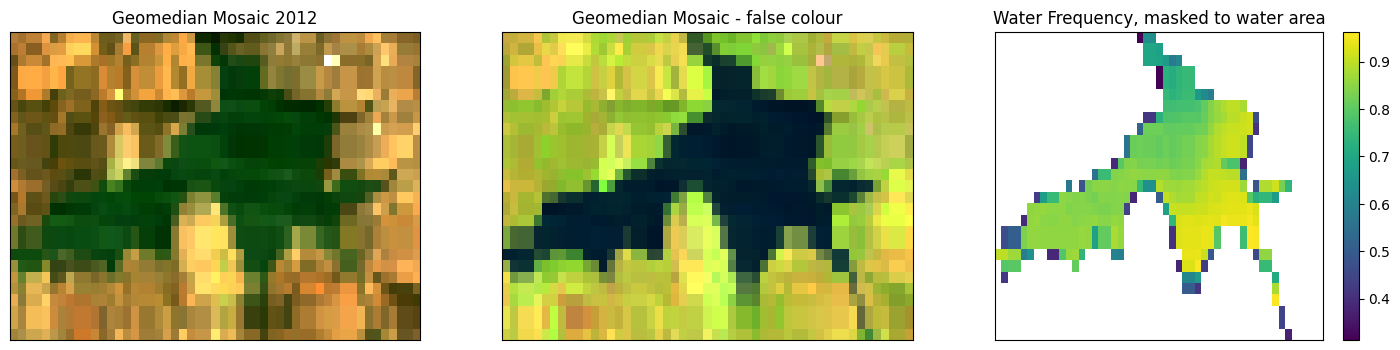

In [663]:
# --- visualise the area ---
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
#ds_annual.water_5yr.mean(dim='time').plot.imshow(ax=ax[2])
(ds.wofs_ann_wetcount.sum(dim='time')/ds.wofs_ann_clearcount.sum(dim='time')).where(ds.water_5yr.mean(dim='time')>0).plot.imshow(ax=ax[2])
#(ds_annual.wofs_ann_wetcount/ds_annual.wofs_ann_clearcount).where(ds_annual.water_5yr>0).mean(dim=('x','y')).plot.step(marker='',color='r',linestyle='-',ax=ax[2])

tindex = int(ds.time.size/2)
if ds.msi_agm[tindex]==True:
    rgb(ds,bands=['msi04_agm','msi03_agm','msi02_agm'],index=tindex,index_dim='time',ax=ax[0])
    rgb(ds,bands=['msi11_agm','msi8a_agm','msi02_agm'],index=tindex,index_dim='time',ax=ax[1])
else: 
    if ds.oli_agm[tindex]==True:
        rgb(ds,bands=['oli04_agm','oli03_agm','oli02_agm'],index=tindex,index_dim='time',ax=ax[0])
        rgb(ds,bands=['oli06_agm','oli05_agm','oli03_agm'],index=tindex,index_dim='time',ax=ax[1])
    else :
        if ds.tm_agm[tindex]==True:    
           rgb(ds,bands=['tm03_agm','tm02_agm','tm01_agm'],index=tindex,index_dim='time',ax=ax[0])
           rgb(ds,bands=['tm05_agm','tm04_agm','tm02_agm'],index=tindex,index_dim='time',ax=ax[1])
     
# Titles
ax[0].set_title("Geomedian Mosaic "+str(pd.DatetimeIndex(ds.time).year[tindex])), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("Geomedian Mosaic - false colour"), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
ax[2].set_title("Water Frequency, masked to water area"), ax[2].xaxis.set_visible(False), ax[2].yaxis.set_visible(False);
#ax[2].set_title("Water extent mask"), ax[2].xaxis.set_visible(False), ax[2].yaxis.set_visible(False);
#ax[2].set_title("Average water frequency"), ax[2].xaxis.set_visible(True), ax[2].yaxis.set_visible(True);


### Calcuate FAI (floating algaL index) and NDVI values:
#### - FAI and NDVI ar used to provide an measure of cyanopbacteria and floating vegetation, this is an important WQ measure.
#### - Pixels with significant NDVI and FAI values need to be excluded from other analyses
#### - Reporting on FAI / NDVI is also valuable. To do this, the 5-year wofs frequency is needed. This variale is called  "wofs_5yr_freq"


In [664]:
# --- run the FAI for annual geomedian based datasets and calculate the percent coverage --- 
#     Multiple fai values are produced, one for each instrument in the geomedian set. 
#     Values are standardised using mean values developed empirically, with MSI taken as the reference becasue there are more msi data. 
#     The FAI function needs to kmow the instrument because the bands used are instrunent-specific
#     Values are masked to a 5-year water mask specific to this purpose

ds = geomedian_FAI(ds,ds.water_5yr)

# --- calculate an annual percentage cover of high FAI
ds['fai_cover'] = \
        ('time'), \
        ((ds.agm_fai.count(dim=('x','y'))  / ds.water_5yr.count(dim=('x','y'))) \
         *100).round(2).data

# -- and save the percentage area affected in the results

annual_results = results['annual_results']
newcolname = 'fai_cover_percent'
if newcolname in annual_results.columns:  annual_results = annual_results.drop(labels=[newcolname],axis=1)
annual_results.insert(annual_results.columns.size,
                      newcolname,
                        ((ds.fai_cover))
                     )
results['annual_results'] = annual_results

In [665]:
# --- Calculate NDVI values for annual geomedians instrument ----
#     NDVI is calculated for each instrument in the series (tm, oli, msi).
#     The overall NDVI is a weighted mean (weighted by the number of observations in each geomedian)

ds = geomedian_NDVI(ds,ds.water_5yr)

ds['ndvi_cover'] = \
        ('time'), \
        ((ds.agm_ndvi.count(dim=('x','y'))  / ds.water_5yr.count(dim=('x','y'))) \
         *100).round(2).data

# -- and save the percentage area affected in the results

annual_results = results['annual_results']
newcolname = 'ndvi_cover_percent'
if newcolname in annual_results.columns:  annual_results = annual_results.drop(labels=[newcolname],axis=1)
annual_results.insert(annual_results.columns.size,
                      newcolname,
                        ((ds.ndvi_cover))
                     )
results['annual_results'] = annual_results


In [666]:
# --- a function to make nice step-plot data; we assume that we're working with time data and that the step intervals are even
def make_stepplot_data(tdata,ydata):
    delta = ((np.datetime64(tdata[1])- np.datetime64(tdata[0]))/2)
    steps = np.array([], dtype='datetime64')
    values = []
    for t in tdata:
        value  = ydata[tdata==t]
        tminus = t - delta
        tplus  = t + delta
        steps  = np.append(steps, [tminus,tplus])
        values = np.append(values,[value ,value])
    return(steps,values)    

In [667]:
# --- view the annual results ---
results['annual_results'].head()
print('Maxiumum observed FAI (%): ',results['annual_results'].fai_cover_percent.max())


Maxiumum observed FAI (%):  24.32


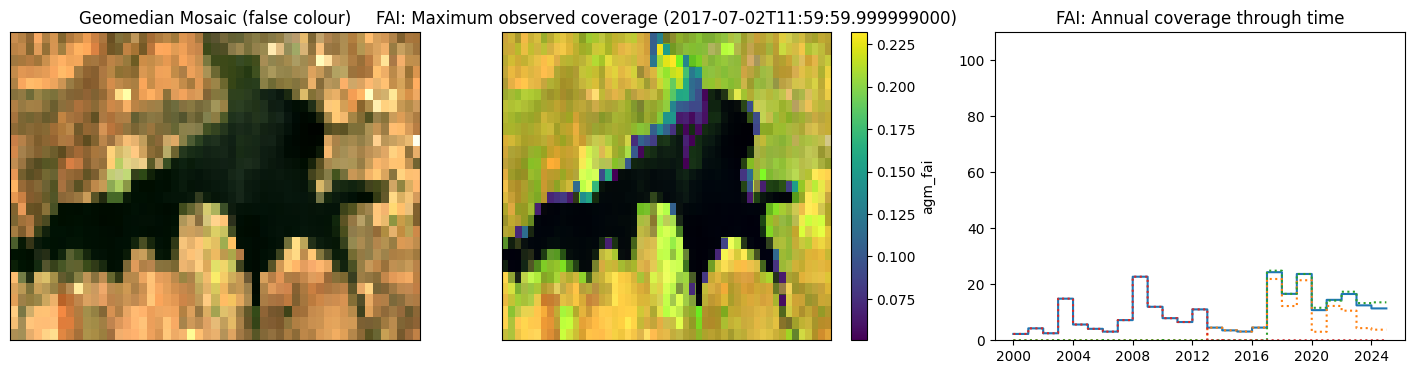

In [668]:
#--- visualise  the annual results and image data
annual_results = results['annual_results']
max_year    = annual_results[annual_results.fai_cover_percent == annual_results.fai_cover_percent.max()].time.values[0]
max_year_index = list(annual_results.time).index(max_year)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[2].set_ylim(0,110)

tindex = max_year_index
if ds.msi_agm[tindex]==True:
    rgb(ds,bands=['msi04_agm','msi03_agm','msi02_agm'],index=tindex,index_dim='time',ax=ax[0])
    rgb(ds,bands=['msi11_agm','msi8a_agm','msi03_agm'],index=tindex,index_dim='time',ax=ax[1])
else: 
    if ds.oli_agm[tindex]==True:
        print('trying oli')
        rgb(ds,bands=['oli04_agm','oli03_agm','oli02_agm'],index=tindex,index_dim='time',ax=ax[0])
        rgb(ds,bands=['oli06_agm','oli05_agm','oli03_agm'],index=tindex,index_dim='time',ax=ax[1])
    else :
        if ds.tm_agm[tindex]==True: 
           rgb(ds,bands=['tm03_agm','tm02_agm','tm01_agm'],index=tindex,index_dim='time',ax=ax[0])
           rgb(ds,bands=['tm05_agm','tm04_agm','tm02_agm'],index=tindex,index_dim='time',ax=ax[1])

ds.sel(time=str(max_year)).agm_fai.plot(ax=ax[1])

t,y = make_stepplot_data(annual_results.time,annual_results.fai_cover_percent)
plt.plot(t,y,label='all data')

for instrument in 'oli_agm','msi_agm','tm_agm':
    if instrument in ds.data_vars:
        y   = (((ds[instrument+'_fai'].count(dim=('x','y')) * parameters['cell_area']) / annual_results.area_km2) * 100).round(2)
        t,y = make_stepplot_data(np.asarray(ds.time),y)
        plt.plot(t,y,linestyle=':',label=instrument)

# Titles
ax[0].set_title("Geomedian Mosaic (false colour)"), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("FAI: Maximum observed coverage ("+str(max_year)+")"), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False);
ax[2].set_title("FAI: Annual coverage through time"), ax[2].xaxis.set_visible(True), ax[2].yaxis.set_visible(True);

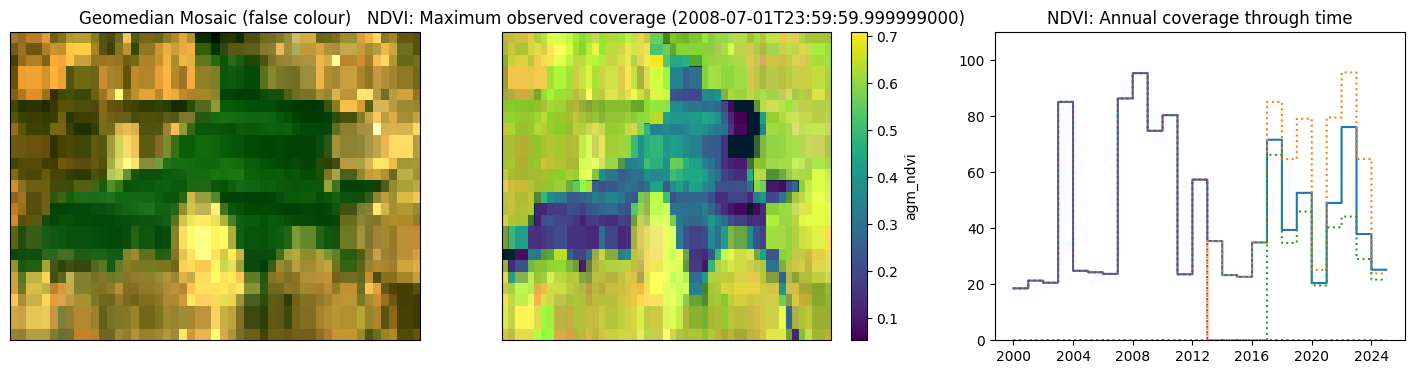

In [669]:
#--- visualise  the annual results and image data
annual_results = results['annual_results']
max_year    = annual_results[annual_results.ndvi_cover_percent == annual_results.ndvi_cover_percent.max()].time.values[0]
max_year_index = list(annual_results.time).index(max_year)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[2].set_ylim(0,110)

tindex = max_year_index
if ds.msi_agm[tindex]==True:
    rgb(ds,bands=['msi04_agm','msi03_agm','msi02_agm'],index=tindex,index_dim='time',ax=ax[0])
    rgb(ds,bands=['msi11_agm','msi8a_agm','msi02_agm'],index=tindex,index_dim='time',ax=ax[1])
else: 
    if ds.oli_agm[tindex]==True:
        rgb(ds,bands=['oli04_agm','oli03_agm','oli02_agm'],index=tindex,index_dim='time',ax=ax[0])
        rgb(ds,bands=['oli06_agm','oli05_agm','oli03_agm'],index=tindex,index_dim='time',ax=ax[1])
    else :
        if ds.tm_agm[tindex]==True: 
           rgb(ds,bands=['tm03_agm','tm02_agm','tm01_agm'],index=tindex,index_dim='time',ax=ax[0])
           rgb(ds,bands=['tm05_agm','tm04_agm','tm02_agm'],index=tindex,index_dim='time',ax=ax[1])

ds.sel(time=str(max_year)).agm_ndvi.plot(ax=ax[1])

t,y = make_stepplot_data(annual_results.time,annual_results.ndvi_cover_percent)
plt.plot(t,y,label='all data')

for instrument in 'oli_agm','msi_agm','tm_agm':
    if instrument in ds.data_vars:
        y   = (((ds[instrument+'_ndvi'].count(dim=('x','y')) * parameters['cell_area']) / annual_results.area_km2) * 100).round(2)
        t,y = make_stepplot_data(np.asarray(ds.time),y)
        plt.plot(t,y,linestyle=':',label=instrument)

# Titles
ax[0].set_title("Geomedian Mosaic (false colour)"), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("NDVI: Maximum observed coverage ("+str(max_year)+")"), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False);
ax[2].set_title("NDVI: Annual coverage through time"), ax[2].xaxis.set_visible(True), ax[2].yaxis.set_visible(True);

In [670]:
# --- Introduce a 'clearwater' mask for areas of water that don't have significant fai values
#     ? should we also test for high NDVI? 
def set_clearwater(ds):
    ds['clearwater'] = xr.where(np.isnan(ds.agm_fai),xr.where(ds.water_5yr==1,True,False),False)
    return(ds)
ds=set_clearwater(ds)

#ds.where(ds.clearwater).isel(time=17).oli03_agm.plot()

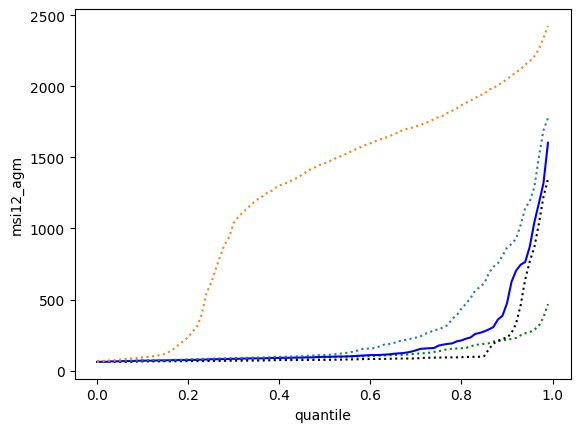

In [671]:
# an exploration of the clearwater mask as a better approach to dark pixel correction

ds.where(ds.clearwater).isel(time=17).msi12_agm.quantile(np.arange(0,1,.01)).plot(color='g',linestyle=':')
ds.where(ds.wofs_ann_water>0).isel(time=17).msi12_agm.quantile(np.arange(0,1,.01)).plot(color='b')
ds.where(ds.wofs_ann_pwater).isel(time=17).msi12_agm.quantile(np.arange(0,1,.01)).plot(linestyle=':',color='k')
ds.where(ds.water_5yr==1).isel(time=17).msi12_agm.quantile(np.arange(0,1,.01)).plot(linestyle=':')
ds.where(True).isel(time=17).msi12_agm.quantile(np.arange(0,1,.01)).plot(linestyle=':',marker='')


### Pixel corrections

In [760]:
del ds1

In [761]:
# Apply a dark-pixel correction; by default dropping the originals
%run _WQ_functions.py
ds0 = ds

ds = apply_R_correction(ds,['msi_agm','oli_agm','tm_agm'],
                   water_mask=ds.water_5yr,
                   drop = True,
                   test = False,verbose=False)
#rgb(apply_R_correction(ds,['msi_agm','oli_agm','tm_agm'],water_mask=ds.clearwater),bands=['msi04_agmr','msi03_agmr','msi02_agmr'],robust=True,index=24,index_dim='time')

---variable -->   msi01_agm   <-- anticipated but not found in the dataset (non-fatal)
---variable -->   oli01_agm   <-- anticipated but not found in the dataset (non-fatal)


### Hue; calculation of the hue value


 Aborting hue calculation for instrument  oli  due to lack of necessary data bands



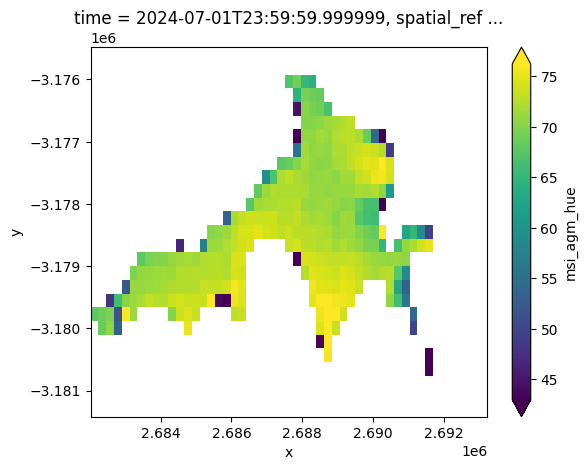

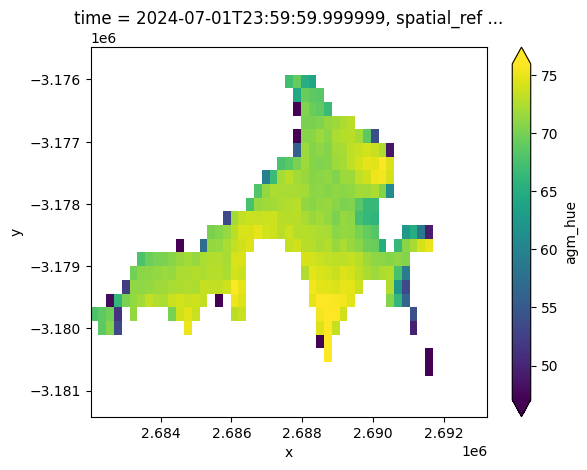

In [673]:
ds = geomedian_hue(ds,ds.clearwater==1,test=True)

ds.isel(time=24).msi_agm_hue.plot(robust=True)
plt.show()
ds.isel(time=24).agm_hue.plot(robust=True)

### Optical Water Type (OWT)
The algorithm compares each pixel's band values with 13 reference spectra based on the spectral angle. Therefore, for each pixel 13 dot products are calculated. 
Memory intensive, data are down-sampled for processing. 
Methods as per Spyrakos et al 2018. - code here caters for msi_agm and oli_agm sensors (ie., the annual geomedian), but easily adapted to msi and oli through dictionary entries
OWT is estimated from the spectral angle between the pixel and the refence spectra for each of the 13 OWTs
- extension to other sensors (TM, OLCI) also quite straightforward but the OWT refence data would need to be brought in.

we can do this for Landsat and for Sentinel, however in the geomedian 
- OLI has only 3 available bands (2,3,4) - missing band 1
- MSI has only 6  of 7 useful bands (missing band 1) 
- TM  has 4  (all of 1,2,3,4)

**To do, ideally : Upload the full reference spectra and establish an import function to bring in as a data array.**
- Here, I have estimated the mean band reflectance for each sensor in excell using the spectral response curves (MSI response functions are available on-line) and used the results directly 

#### Zhang et al. group the OWTs as follows:
- oligotrophic (clear)           : 3, 9, 13           (apply NASA OCx model for ChlA) - we don't see much of this!!!
- eutopic and bluegreen waters   : 1, 2, 4, 5, 11, 12 (apply two band models of Gurlin et al for ChlA)
- hypereutrophic and green-brown : 6, 7, 8, 10        (apply TC2 alg for ChlA)   

#### The first step : read in the spectral curves for each optial water type, and model the response vectors for each sensor and band
- this information tells us what we expect each owt to look like, for each sensor (msi, oli, tm)

#### Now we compare each pixel vector to what we would expect for each OWT, and pick the closest one
- the spectral angle is used to identify the OWT that is closest to the observed values

In [830]:
%run _WQ_functions.py


In [831]:
def run_OWT(ds):
    OWT_vector_data = create_OWT_response_models(agm=True)
    suffix = '_agm'
    for instrument in 'msi','oli','tm':
        if instrument+suffix in ds.data_vars:
            OWT_vectors = OWT_vector_data[instrument]    # the spectral reflectances specific to this sensor
            OWT_data    = OWT(ds.where(ds.clearwater==1),
                          instrument,
                          OWT_vectors,
                          agm=True,
                          test=False, 
                          verbose=True) 
        varname = instrument+'_agm_owt'
        if varname in ds.data_vars:
            ds[varname] = xr.where(~np.isnan(OWT_data),OWT_data,ds[varname])
        else : 
            ds[varname] = OWT_data
        del OWT_data
    return(ds)
    gc.collect()
ds0 = run_OWT(ds0)


 calculating optical water type (OWT), sensor =  msi  ....

....done
Prevailng water type is  3.0  :   oligotrophic (clear)

 calculating optical water type (OWT), sensor =  oli  ....

....done
Prevailng water type is  6.0  :   hyper-eutrophic and green-brown

 calculating optical water type (OWT), sensor =  tm  ....

....done
Prevailng water type is  1.0  :   eutrophic and blue-green


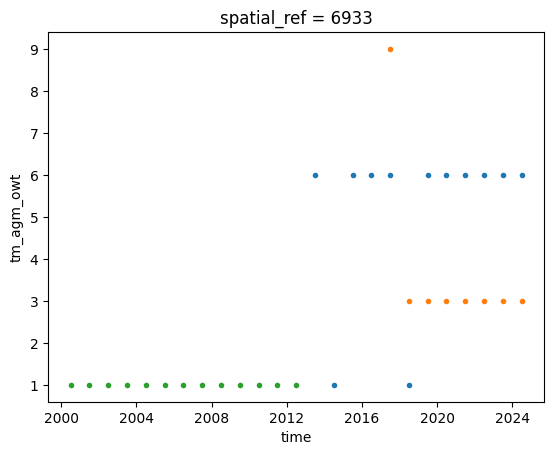

In [832]:
ds0.oli_agm_owt.median(dim=('x','y')).plot(linestyle='',marker='.')
ds0.msi_agm_owt.median(dim=('x','y')).plot(linestyle='',marker='.')
ds0.tm_agm_owt.median(dim=('x','y')).plot(linestyle='',marker='.')


### Calculate the raw (i.e. not harmonised) water quality measurements and indices
- A dictionary is used to manage water quality algorithms and the bands that are used in them. This retains flexibility (e.g. algorithms can be run with multiple sensors) and avoids errors
- NEW DIMENSIONS are added to the dataset to house the results. One dimension is added called 'chla', and one called 'tss'. This appraoch simplifies later processing when we want to pool the measures as an ensemble. (For simplicity, I may remove this and bring in at a later stage..)



In [53]:
# ----  dictionary of instruments, bands, algorithms, and  functions -----------------------   

ndci_nir_r   =  { 
                "msi_agm"   : {'54' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi54_agm'       ,'args' : {"NIR_band" : 'msi05_agmr', "red_band":'msi04_agmr'}},
                               '64' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi64_agm'       ,'args' : {"NIR_band" : 'msi06_agmr', "red_band":'msi04_agmr'}},
                               '74' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi74_agm'       ,'args' : {"NIR_band" : 'msi07_agmr', "red_band":'msi04_agmr'}}},
                "tm_agm"    : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_tm43_agm'                ,'args' : {"NIR_band" : 'tm04_agm'  , "red_band":'tm03_agmr'}},
                "oli_agm"   : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_oli54_agm'               ,'args' : {"NIR_band" : 'oli05_agm' , "red_band":'oli04_agmr'}}
                }

chla_meris2b = {"msi_agm" : {'func': ChlA_MERIS2B, "wq_varname" : 'chla_meris2b_msi_agm' ,'args' : {"band_708" : 'msi05_agmr', "band_665":'msi04_agmr'}},
                    "msi"     : {'func': ChlA_MERIS2B, "wq_varname" : 'chla_meris2b_msi'     ,'args' : {"band_708" : 'msi05'     , "band_665":'msi04'}}}

chla_modis2b = {"msi_agm" : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_msi_agm' ,'args' : {"band_748" : 'msi06_agmr', "band_667":'msi04_agmr'}},
                    "msi"     : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_msi'     ,'args' : {"band_748" : 'msi06'     , "band_667":'msi04'}},
                    "tm_agm"  : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_tm_agm'  ,'args' : {"band_748" : 'tm04_agmr' , "band_667":'tm03_agmr'}}}

ndssi_rg     = {"msi_agm" : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_msi_agm'       ,'args' : { "red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                "msi"     : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_msi'           ,'args' : { "red_band":'msi04r'    , "green_band":'msi03_agmr'}},
                "oli_agm" : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_oli_agm'       ,'args' : { "red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                "oli"     : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_oli'           ,'args' : { "red_band":'oli04r'    , "green_band":'oli03r'    }},
                "tm_agm"  : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_tm_agm'        ,'args' : { "red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                "tm"      : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_tm'            ,'args' : { "red_band":'tm03r'     , "green_band":'tmi02r'    }}}

ndssi_bnir   = {#"msi_agm" : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_msi_agm'     ,'args' : { "NIR_band":'msi08_agmr', "blue_band":'msi02_agmr'}},
                "msi"     : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_msi'         ,'args' : { "NIR_band":'msi08'     , "blue_band":'msi02_agmr'}},
                "oli_agm" : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_oli_agm'     ,'args' : { "NIR_band":'oli06_agm' , "blue_band":'oli02_agmr'}},
                "oli"     : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_oli'         ,'args' : { "NIR_band":'oli06'     , "blue_band":'oli02r'    }},
                #"tm_agm"  : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_tm_agm'      ,'args' : { "NIR_band":'tm04_agm'  , "blue_band":'tm01_agmr' }},
                "tm"      : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_tm'          ,'args' : { "NIR_band":'tm04'     , "blue_band":'tm01r'    }}}


ti_yu        = {#"msi_agm" : {'func': TI_yu,        "wq_varname" : 'ti_yu_msi_agm'        ,'args' : {"NIR" : 'msi08_agmr', "Red":'msi04_agmr', "Green":'msi03_agmr'}},
                    "msi"     : {'func': TI_yu,        "wq_varname" : 'ti_yu_msi'            ,'args' : {"NIR" : 'msi08'     , "Red":'msi04r'    , "Green":'msi03_agmr'}},
                    "oli_agm" : {'func': TI_yu,        "wq_varname" : 'ti_yu_oli_agm'        ,'args' : {"NIR" : 'oli06_agm' , "Red":'oli04_agmr', "Green":'oli03_agmr'}},
                    "oli"     : {'func': TI_yu,        "wq_varname" : 'ti_yu_oli'            ,'args' : {"NIR" : 'oli06'     , "Red":'oli04r'    , "Green":'oli03r'    }},
                    "tm_agm"  : {'func': TI_yu,        "wq_varname" : 'ti_yu_tm_agm'         ,'args' : {"NIR" : 'tm04_agm'  , "Red":'tm03_agmr' , "Green":'tm02_agmr' }},
                    "tm"      : {'func': TI_yu,        "wq_varname" : 'ti_yu_tm'             ,'args' : {"NIR" : 'tm04'      , "Red":'tm03r'     , "Green":'tmi02r'    }}}

tsm_lym      = {"oli_agm" : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_oli_agm'        ,'args' : {"red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                    "oli"     : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_oli'            ,'args' : {"red_band":'oli04r'    , "green_band":'oli03r'    }},
                    "msi_agm" : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_msi_agm'        ,'args' : {"red_band":'msi04_agmr', "green_band":'msi03_agmr' }},
                    "msi"     : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_msi'            ,'args' : {"red_band":'msi04r'    , "green_band":'msi03r'    }},
                    "tm_agm"  : {'func': TSM_LYM_ETM,  "wq_varname" : 'tsm_lym_tm_agm'         ,'args' : {"red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                    "tm"      : {'func': TSM_LYM_ETM,  "wq_varname" : 'tsm_lym_tm'             ,'args' : {"red_band":'tm03r'     , "green_band":'tm02r'     }}}

spm_qiu      = {"oli_agm" : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_oli_agm'        ,'args' : {"red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                    "oli"     : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_oli'            ,'args' : {"red_band":'oli04r'    , "green_band":'oli03r'    }},
                    "tm_agm"  : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_tm_agm'         ,'args' : {"red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                    "tm"      : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_tm'             ,'args' : {"red_band":'tm03r'     , "green_band":'tm02r'     }},
                    "msi_agm" : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_msi_agm'        ,'args' : {"red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                    "msi"     : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_msi'            ,'args' : {"red_band":'msi04r'    , "green_band":'msi03r'    }}}

tss_zhang        = {"msi_agm" : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_msi_agm' ,'args' : {"blue_band" : 'msi02_agmr', "red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                        "msi"     : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_msi'     ,'args' : {"blue_band" : 'msi02r'    , "red_band":'msi04r'    , "green_band":'msi03_agmr'}},
                        "oli_agm" : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_oli_agm' ,'args' : {"blue_band" : 'oli02_agmr', "red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                        "oli"     : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_oli'     ,'args' : {"blue_band" : 'oli02r'    , "red_band":'oli04r'    , "green_band":'oli03r'    }}}

# ---- algorithms are grouped into two over-arching dictionaries ---- 
algorithms_chla = {"ndci_nir_r"   : ndci_nir_r, 
                       "chla_meris2b" : chla_meris2b, 
                       "chla_modis2b" : chla_modis2b}
algorithms_tsm  = {"ndssi_rg"     : ndssi_rg  , 
                       "ndssi_bnir"   : ndssi_bnir, 
                       "ti_yu"        : ti_yu     ,
                       "tsm_lym"      : tsm_lym   ,
                       "tss_zhang"    : tss_zhang ,
                       "spm_qiu"      : spm_qiu    }

In [54]:
# ---- Apply the WQ algorithms to water areas, adding variables to the dataset and building  a list of water quality variable nanmes
# -- this can be run either keeping the wq variables as separate variables on the dataset, or by moving them into new dimensions, 'tss' and 'chla'
# -- If the arguments 'new_dimension_name' or 'new_varname' are None (or empty), then the outputs will be retained as separate variables in a 3d dataset

# For simplicity, set a 'clearwater' array as a mask for processing the water quality variables:


if True: #put the data into a new dimension, call the variable 'tss' or 'chla'
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments, 
                        new_dimension_name='tss_measure', 
                        new_varname='tss', 
                        verbose=verbose)
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments, 
                        new_dimension_name='chla_measure', 
                        new_varname='chla',
                        verbose=verbose)

else:  #keep it simple, just add new data as new variables in a 3-D dataset 
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments, 
                        new_dimension_name=None, 
                        new_varname=None, 
                        verbose=verbose)
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments, 
                        new_dimension_name=None, 
                        new_varname=None,
                        verbose=verbose)
wq_varlist = np.append(tsm_vlist,chla_vlist)


NDSSI_RG
NDSSI_RG
NDSSI_RG
NDSSI_BNIR
TI_yu
TI_yu
TSM_LYM_OLI
TSM_LYM_OLI
TSM_LYM_ETM
TSS_Zhang
TSS_Zhang
SPM_QIU
SPM_QIU
SPM_QIU
ChlA_MERIS two-band model
ChlA_MODIS two-band model
ChlA_MODIS two-band model


In [55]:
# ---- tidy up by dropping excess variables ---
keeplist = ('wofs_ann_clearcount','wofs_ann_wetcount','wofs_ann_freq','wofs_ann_freq_sigma','wofs_pw_threshold','wofs_ann_pwater','watermask','owt_msi','tss','chla')
#the keeplist is not complete; if the wq variables are retained as variables they will appear in a listing of data_vars. 
#therefore, revert to the instruments dictionary to list variables to drop
droplist = []
for instrument in list(instruments.keys()):
    for band in list(instruments[instrument].keys()):
        variable = instruments[instrument][band]['varname']
        if not (variable in keeplist): 
            droplist=np.append(droplist,variable)
            droplist=np.append(droplist,variable+'r')
for varname in droplist:
    if varname in ds.data_vars:
        ds = ds.drop_vars(varname)
    

### And we are Done... :)

In [116]:
ds['wofs_ann_confidence'] = xr.where(ds.wofs_ann_freq >0,
            ((1.0 - (ds.wofs_ann_freq_sigma/ds.wofs_ann_freq)) * 100).astype('int16'),
            np.nan)

/opt/venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:236: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [ ]:
#export the dataset as an input for the next step:
ds.to_netcdf("../WP1.4/wp12_ds_"+placename+".nc")

In [58]:
placename

'Lake Chomo'

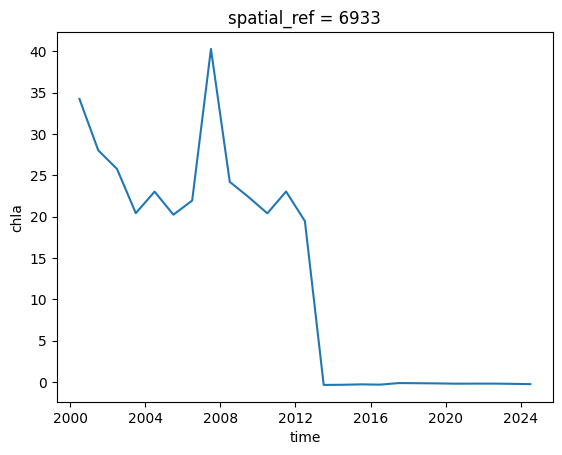

In [59]:
ds.chla.median(dim=('chla_measure')).median(dim=('x','y')).plot()

In [42]:

ds.data_vars


Data variables:
    wofs_ann_freq        (time, y, x) float32 7MB nan nan nan ... 1.0 1.0 1.0
    wofs_ann_clearcount  (time, y, x) float64 14MB nan nan nan ... 28.0 27.0
    wofs_ann_wetcount    (time, y, x) float64 14MB nan nan nan ... 28.0 27.0
    wofs_ann_freq_sigma  (time, y, x) float64 14MB nan nan nan ... 0.0 0.0 0.0
    wofs_ann_confidence  (time, y, x) float64 14MB nan nan nan ... 100.0 100.0
    wofs_pw_threshold    (time, y, x) float64 14MB nan nan nan ... 0.875 0.875
    wofs_ann_pwater      (time, y, x) float32 7MB nan nan nan ... 1.0 1.0 1.0
    wofs_ann_water       (time, y, x) float32 7MB nan nan nan ... 1.0 1.0 1.0
    watermask            (time, y, x) float64 14MB nan nan nan ... 0.0 0.0 0.0
    hue                  (time, y, x) float64 14MB nan nan nan ... 40.3 40.39
    owt_msi              (time, y, x) float64 14MB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 141MB nan ... 126.5
    chla                 (time, y, x, chla_m